# Fairytale: Generating Story using Fine-tuned GPT-2 Model


## Alan Du, Navid Hasanzadeh

Children’s tales are extremely important in child development as they improve literacy skills, communication skills, and assist with forming ideas of culture/race. Each story contains lessons that highlight important societal values and show children what is right and wrong. 
Our project, Fairytale, aims to allow anyone to generate a children’s tale with a simple prompt and choose what core values they want to appear in the text, what genre the story is, and the targeted age range.


### Reference
Some parts of this code were borrowed and then customized from an available code for fine-tuning GPT models on HuggingFace:

https://huggingface.co/ritwikm/gandhi-gpt/blob/37e8d86c2c884794683f2cdbeca593e84f962f92/code/gpt-finetune.py


# Setup

In [1]:
# !pip install transformers
import warnings
warnings.filterwarnings('ignore')
import shutup; shutup.please()

In [2]:
import os
import time
import datetime

import pandas as pd
import seaborn as sns
import numpy as np
import random

import matplotlib.pyplot as plt
%matplotlib inline

import torch
from torch.utils.data import Dataset, DataLoader, random_split, RandomSampler, SequentialSampler
torch.manual_seed(42)

from transformers import GPT2LMHeadModel,  GPT2Tokenizer, GPT2Config, GPT2LMHeadModel
from transformers import AdamW, get_linear_schedule_with_warmup

import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\16478\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

# Story Pre-processing and Labelling

We collected 720 stories from various sources on the Internet. These texts vary from 100-500 words in length. Each story is labeled with the genre, 2 age ratings, and values in with the text. Below are the steps we used to process our data:

1. Clean the text (remove leading/trailing whitespace and non-UTF8 characters)

2. Manually trim word count if story is longer than 500 words

3. Skim through the story and assign values present in the story

4. Manually assign genre if available or generate a predicted genre using a pre-trained genre predicting model [3]

5. Generate age and kids labels.

    a) Age label represents the corresponding US grade level (i.e. age = 3 is grade 3). This was calculated using an average grade score of 8 different standardized text difficulty scales.
    
    b) Kids label represents the presence of kids appropriate words in the text based off the Cambridge criterion for English vocabulary

We also used a oublic dataset with more than 30,000 stories with defferent genres.

In [17]:
from pathlib import Path 
filename = "final_data_for_gpt2.txt"
base_path = "./"
text = Path(base_path, filename).read_text(encoding='utf-8')

In [18]:
stories = text.split('\n')
stories = [s.strip() for s in stories if len(s)>1]

In [21]:
sample_story = stories[1]
print(sample_story)

<drama> Life is going along smoothly for Jeff and Mari Thompson but not for any other couple they know, or so it seems. Everyone they know is getting divorced.  Their life is disrupted when Mari's old college friend, Barbara, comes into it and begins a fling with Jeff, which causes Mari to contemplate an affair of her own.


In [22]:
from data.process_genre import get_genre as get_genre_old
from data.process_age import calculate_grade
from data.process_age import is_for_kids

In [25]:
genre_dict = {"sci_fi": "science_fiction", "horror": "horror", "action": "horror", 
              "thriller": "horror", "drama": "realistic_fiction", "superhero":"fantasy"}

In [26]:
def get_genre(story):
    return genre_dict[get_genre_old(story)]

In [27]:
def add_labels(story):
    if "<" and ">" in story[:50]:
        grade = str(int(calculate_grade(story)))
        sample_processed_story = "<{}> ".format(grade)  + story
        for g in genre_dict.keys():
            if "<" + g + ">" in sample_processed_story:
                sample_processed_story = sample_processed_story.replace("<" + g + ">", "<" + genre_dict[g] + ">")
                break
    else:
        story = story.split('\t')[1].replace('"',"").replace("\'","")
        genre = get_genre(story)
        grade = str(int(calculate_grade(story)))
        sample_processed_story = "<{}> <{}>".format(grade, genre)  + story
    return sample_processed_story

In [28]:
add_labels(stories[-5])

'<2> <realistic_fiction> Kenny was crying. Why are you crying? Mom asked Kenny. The cat scratched me, said Kenny. The cat had scratched Kenny on his hand. Kenny showed his hand to his mom. The scratch didnt look too bad. It wasnt a deep scratch. Mom went to the kitchen. Kenny went with her. She turned on the water. She put his hand under the water. She washed the scratch with soap. She rinsed off the soap. She took a Band-Aid out of the kitchen cabinet. She put the Band-Aid on the scratch. She said he would be okay. Why did the cat scratch you? she asked. Kenny said he didnt know why the cat scratched him. Just then, Kennys little sister walked into the kitchen. She knew why the cat scratched Kenny. I know why Tiger scratched him, Mommy, she said. He was pulling Tigers tail!'

In [29]:
add_labels(stories[0])

'<6> <horror> Prince (Vivek Oberoi) is a sharp and intelligent burglar, but when he awakes one morning, he finds that he does not remember anything about his past. He goes to a club and meets a girl who claims to be his girlfriend Maya. The next day, he meets a second girl who claims to be his girlfriend named Maya. She also claims that they work for the police and are after a man named Sarang. She reveals that they must find a special coin and give it to Sarang, after which the cops will arrest him. This coin has a chip in it that can go into one\'s mind and change one\'s thoughts completely.  They find the coin inside Prince\'s shoe and give it to Sarang. Prince finds out that the second "Maya" is really a woman named Serena who works for Sarang. His servant P.K. works for Sarang along with her. The coin is revealed to be a fake. Just as Prince is trapped, the real Maya, who is in fact his girlfriend, saves him and tells him the actual story. The chip was put inside Prince so that he

In [30]:
from tqdm import tqdm

In [19]:
print("# Total stories in step 1: ", len(stories))
processed_stories = []
for i in tqdm(range(len(stories))):
    try:
        processed_stories.append(add_labels(stories[i]))
    except:
        pass

# Total stories in step 1:  33039


100%|████████████████████████████████████████████████████████████████████████████| 33039/33039 [22:05<00:00, 24.92it/s]


In [34]:
df = pd.DataFrame(processed_stories,columns =['story'])

In [35]:
df.dropna(inplace=True) #remove NA values
df_story = df.story.copy() #just use the main bio text in this example
print(df_story)

0        <6> <horror> Prince (Vivek Oberoi) is a sharp ...
1        <8> <realistic_fiction> Life is going along sm...
2        <6> <realistic_fiction> A young girl suddenly ...
3        <7> <realistic_fiction> Varghese (Mohanlal) is...
4        <9> <horror> When Adrien Williams is released ...
                               ...                        
33034    <2> <realistic_fiction> Kenny was crying. Why ...
33035    <2> <horror> It is December. That means it is ...
33036    <4> <realistic_fiction> Present What do you wa...
33037    <1> <realistic_fiction> Rex is very sick, Lucy...
33038    <2> <horror> Watching Lets go to the beach, Da...
Name: story, Length: 33039, dtype: object


In [22]:
# df_story.to_csv("labelled_data.csv", index=False)

In [58]:
df_story = pd.read_csv("labelled_data.csv")
df_story.dropna(inplace=True)
df_story = df_story.story
print(df_story)

0        <6> <horror> Prince (Vivek Oberoi) is a sharp ...
1        <8> <realistic_fiction> Life is going along sm...
2        <6> <realistic_fiction> A young girl suddenly ...
3        <7> <realistic_fiction> Varghese (Mohanlal) is...
4        <9> <horror> When Adrien Williams is released ...
                               ...                        
33034    <2> <realistic_fiction> Kenny was crying. Why ...
33035    <2> <horror> It is December. That means it is ...
33036    <4> <realistic_fiction> Present What do you wa...
33037    <1> <realistic_fiction> Rex is very sick, Lucy...
33038    <2> <horror> Watching Lets go to the beach, Da...
Name: story, Length: 33039, dtype: object


In [36]:
# count the number of stories in each genre
genre_count = {"science_fiction": 0, "horror": 0, "realistic_fiction": 0, "fantasy": 0}
for s in processed_stories:
    for g in set(genre_dict.values()):
        if "<" + g + ">" in s:
            genre_count[g] += 1
            break

In [37]:
genre_count

{'science_fiction': 1026,
 'horror': 11723,
 'realistic_fiction': 20003,
 'fantasy': 287}

Text(0, 0.5, '# Stories')

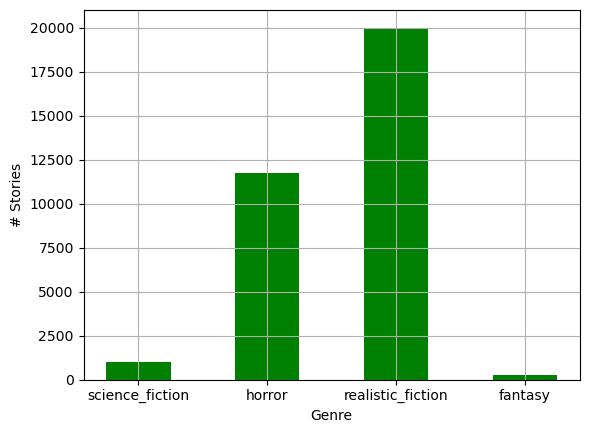

In [38]:
import matplotlib.pyplot as plt
plt.bar(genre_count.keys(), genre_count.values(), 0.5, color='g')
plt.grid()
plt.xlabel("Genre")
plt.ylabel("# Stories")

# GPT2 Tokenizer

In [44]:
# Load the GPT tokenizer.
tokenizer = GPT2Tokenizer.from_pretrained('gpt2', bos_token='<|startoftext|>', eos_token='<|endoftext|>', pad_token='<|pad|>') #gpt2-medium
new_tokens = ["<{}>".format(g + 1) for g in range(12)]
new_tokens.extend(["<adult>", "<kids>"])
new_tokens.extend(list(set(genre_dict.values())))
print(new_tokens)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


['<1>', '<2>', '<3>', '<4>', '<5>', '<6>', '<7>', '<8>', '<9>', '<10>', '<11>', '<12>', '<adult>', '<kids>', 'horror', 'realistic_fiction', 'science_fiction', 'fantasy']


In [45]:
# number of tokens in tokenizer before adding the new tokens
len(tokenizer)

50259

In [46]:
for t in new_tokens:
    tokenizer.add_tokens(t)

In [47]:
# number of tokens in tokenizer after adding the new tokens
len(tokenizer)

50277

# PyTorch Datasets & Dataloaders


GPT2 is a large model. Increasing the batch size above 2 has lead to out of memory problems. This can be mitigated by accumulating the gradients but that is out of scope here.

In [59]:
batch_size = 4

I'm using the standard PyTorch approach of loading data in using a [dataset class](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html).

I'm passing in the tokenizer as an argument but normally I would  instantiate it within the class.

In [60]:
class GPT2Dataset(Dataset):

  def __init__(self, txt_list, tokenizer, gpt2_type="gpt2", max_length=512):

    self.tokenizer = tokenizer
    self.input_ids = []
    self.attn_masks = []

    for txt in txt_list:

      encodings_dict = tokenizer('<|startoftext|>'+ txt + '<|endoftext|>', truncation=True, max_length=max_length, padding="max_length")

      self.input_ids.append(torch.tensor(encodings_dict['input_ids']))
      self.attn_masks.append(torch.tensor(encodings_dict['attention_mask']))
    
  def __len__(self):
    return len(self.input_ids)

  def __getitem__(self, idx):
    return self.input_ids[idx], self.attn_masks[idx] 

In [61]:
dataset = GPT2Dataset(df_story, tokenizer, max_length=512)

train_split_ratio = 0.9

train_size = int(train_split_ratio * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

29,735 training samples
3,304 validation samples


In [62]:
train_dataloader = DataLoader(train_dataset,sampler = RandomSampler(train_dataset),batch_size = batch_size)

validation_dataloader = DataLoader(val_dataset,sampler = SequentialSampler(val_dataset),batch_size = batch_size)

# Finetuning GPT2 Language Model (First step)

In [63]:
configuration = GPT2Config.from_pretrained('gpt2', output_hidden_states=False)

model = GPT2LMHeadModel.from_pretrained("gpt2", config=configuration)

In [64]:
model.resize_token_embeddings(len(tokenizer))
device = torch.device("cuda")
model.to(device)

seed_val = 20

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [69]:
epochs = 8
learning_rate = 5e-4
warmup_steps = 1e2
epsilon = 1e-8
sample_every = 100

In [70]:
optimizer = AdamW(model.parameters(), lr = learning_rate, eps = epsilon)

In [71]:
total_steps = len(train_dataloader) * epochs

scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps = warmup_steps, num_training_steps = total_steps)

In [72]:
def format_time(elapsed):
    return str(datetime.timedelta(seconds=int(round((elapsed)))))

In [73]:
# For this part we used and customized the code available in: https://github.com/sfs0126/Lyric-Generator-fine-tuned-GPT-2
total_t0 = time.time()

training_stats = []
val_losses = []
model = model.to(device)

output_dir = './gpt2_all_story_model_save_huggingface/'

if not os.path.exists(output_dir):
    os.makedirs(output_dir)

for epoch_i in range(0, epochs):

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    t0 = time.time()

    total_train_loss = 0

    model.train()

    for step, batch in enumerate(train_dataloader):

        b_input_ids = batch[0].to(device)
        b_labels = batch[0].to(device)
        b_masks = batch[1].to(device)

        model.zero_grad()        

        outputs = model(  b_input_ids,
                          labels=b_labels, 
                          attention_mask = b_masks,
                          token_type_ids=None
                        )

        loss = outputs[0]  

        batch_loss = loss.item()
        total_train_loss += batch_loss
        loss.backward()
        optimizer.step()
        scheduler.step()

    avg_train_loss = total_train_loss / len(train_dataloader)       
    
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(training_time))
    print("")
    print("Running Validation...")

    t0 = time.time()

    model.eval()

    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        b_input_ids = batch[0].to(device)
        b_labels = batch[0].to(device)
        b_masks = batch[1].to(device)
        
        with torch.no_grad():        

            outputs  = model(b_input_ids, 
#                            token_type_ids=None, 
                             attention_mask = b_masks,
                            labels=b_labels)
          
            loss = outputs[0]  
            
        batch_loss = loss.item()
        total_eval_loss += batch_loss        

    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    validation_time = format_time(time.time() - t0)    
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))
    
    val_losses.append(avg_val_loss)
    # Save the model with best accuracy on the validation set
    if (len(val_losses)>1 and avg_val_loss < np.min(val_losses[:-1])) or len(val_losses)==1:
        model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
        model_to_save.save_pretrained(output_dir)
        tokenizer.save_pretrained(output_dir)

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")
print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 8 ========
Training...

  Average training loss: 2.38
  Training epoch took: 0:20:03

Running Validation...
  Validation Loss: 2.24
  Validation took: 0:00:40

======== Epoch 2 / 8 ========
Training...

  Average training loss: 2.17
  Training epoch took: 0:20:19

Running Validation...
  Validation Loss: 2.21
  Validation took: 0:00:40

======== Epoch 3 / 8 ========
Training...

  Average training loss: 2.01
  Training epoch took: 0:20:03

Running Validation...
  Validation Loss: 2.18
  Validation took: 0:00:40

======== Epoch 4 / 8 ========
Training...

  Average training loss: 1.86
  Training epoch took: 0:20:16

Running Validation...
  Validation Loss: 2.19
  Validation took: 0:00:40

======== Epoch 5 / 8 ========
Training...

  Average training loss: 1.71
  Training epoch took: 0:21:05

Running Validation...
  Validation Loss: 2.21
  Validation took: 0:00:52

======== Epoch 6 / 8 ========
Training...

  Average training loss: 1.58
  Training epoch took: 0:22:06


The summary of the training process:

In [74]:
df_stats = pd.DataFrame(data=training_stats)
df_stats = df_stats.set_index('epoch')
df_stats

,Training Loss,Valid. Loss,Training Time,Validation Time
epoch,,,,
1,2.376741,2.239332,0:20:03,0:00:40
2,2.171103,2.206378,0:20:19,0:00:40
3,2.012033,2.183592,0:20:03,0:00:40
4,1.859011,2.188050,0:20:16,0:00:40
5,1.713134,2.206928,0:21:05,0:00:52
6,1.575145,2.251367,0:22:06,0:00:44
7,1.448774,2.325907,0:22:29,0:00:45
8,1.342893,2.390391,0:22:39,0:00:46


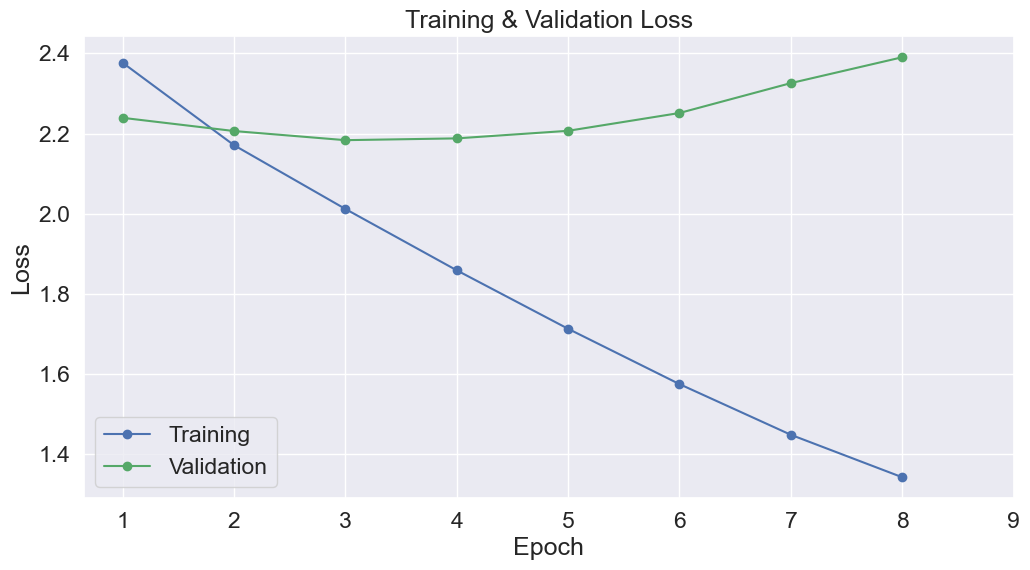

In [75]:
# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([i+1 for i in range(1+len(df_stats['Training Loss']))])

plt.show()

# Display Model Info

In [77]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [79]:
print("# Model parameters: ", count_parameters(model))

# Model parameters:  124455168


# Saving & Loading Fine-Tuned Model


In [49]:
# output_dir = './gpt2_all_story_model_save_huggingface/'

# if not os.path.exists(output_dir):
#     os.makedirs(output_dir)

# model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
# model_to_save.save_pretrained(output_dir)
# tokenizer.save_pretrained(output_dir)



Saving model to ./gpt2_all_story_model_save_huggingface/


('./gpt2_all_story_model_save_huggingface/tokenizer_config.json',
 './gpt2_all_story_model_save_huggingface/special_tokens_map.json',
 './gpt2_all_story_model_save_huggingface/vocab.json',
 './gpt2_all_story_model_save_huggingface/merges.txt',
 './gpt2_all_story_model_save_huggingface/added_tokens.json')

In [80]:
# Loading the model with best performance on validation set
configuration = GPT2Config.from_pretrained('./gpt2_all_story_model_save_huggingface/', output_hidden_states=False)
model = GPT2LMHeadModel.from_pretrained('./gpt2_all_story_model_save_huggingface/', config=configuration)
model.resize_token_embeddings(len(tokenizer))
device = torch.device("cuda")
model.to(device)

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50277, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0): GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
      (1): GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dro

# Generate Text

In [85]:
model.eval()

prompt = "<|startoftext|> <6> <science_fiction>"

generated = torch.tensor(tokenizer.encode(prompt)).unsqueeze(0)
generated = generated.to(device)

sample_outputs = model.generate(generated, do_sample=True, top_k=50, max_length = 200,top_p=0.95, num_return_sequences=1)

for i, sample_output in enumerate(sample_outputs):
  print("{}: {}\n\n".format(i, tokenizer.decode(sample_output, skip_special_tokens=True)))

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


0: <6> < science_fiction > John, a scientist and his partner, travel on a ship that is about to be destroyed. They arrive at a small island near the ocean floor. There, they meet up with the giant octopus, who gives them directions to a nearby island. After a brief fight, John saves the octopus, and his girlfriend, Sarah, becomes fascinated by the island.  John and Sarah fall for each other, and one day John's boss, Dr. David, falls for Sarah. John and Sarah's feelings for each other are immediately mutual, and John discovers their bond with each other. The discovery of the island results in John and Sarah having to stay on the island until they realize that the island is filled with lifeforms. After they leave, John and Sarah find the island's only occupants: a giant octopus, a giant octopus, a giant octopus, and an ugly, silent, silent, silent makoose that is now on the island. Dr




In [87]:
model.eval()

prompt = "<|startoftext|> <4> <horror>"

generated = torch.tensor(tokenizer.encode(prompt)).unsqueeze(0)
generated = generated.to(device)

sample_outputs = model.generate(generated, do_sample=True, top_k=50, max_length = 200,top_p=0.95, num_return_sequences=1)

for i, sample_output in enumerate(sample_outputs):
  print("{}: {}\n\n".format(i, tokenizer.decode(sample_output, skip_special_tokens=True)))

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


0: <4> < horror > The waiter at the general store wasnt buying a meal. He sold the restaurant. The waiter walked in. He walked out of the restaurant. He got into the store and into the main store. He walked in. The waiter rang the bell at 8:05 in two hours. The waiter asked the waiter to put the bell back on. The waiter walked up to the woman who was watching the waiter. She opened the waiter's shirt and put it on. She called the woman. The waiter handed her $20 bill to the waiter. She thanked the waiter for his service. He went to the waiter's table. He went to the main store again. He got in touch with an employee who was smoking outside. He found a picture of the waiter and his wife with a cigarette lighter. He went downstairs to find them. The waiter came to the table. A fight ensues. The waiter tried to fight back. He couldnt do it. He got into




In [88]:
def filter_logits(logits, tokenizer, words):
    for word in words:
        idx = tokenizer.encode(" " + word.strip())[0]
        logits[idx] = -float('Inf')

In [89]:
def add_bias_logits(logits, tokenizer, bias_dict):
    for idx in bias_dict.keys():        
        logits[int(idx)] = logits[int(idx)] + bias_dict[idx]

In [90]:
from numpy.random import choice
import torch.nn.functional as F
def filtered_generate(model, tokenizer, idx, device, max_new_tokens=10, temperature=1.0, do_sample=False,\
                      top_k=None, filter_words = [], bias_words = {}, prevent_repition=False, prevent_repition_bias=1):
    """
    Take a conditioning sequence of indices idx (LongTensor of shape (b,t)) and complete
    the sequence max_new_tokens times, feeding the predictions back into the model each time.
    Most likely you'll want to make sure to be in model.eval() mode of operation for this.
    """
    idx_all = []
    top_k_probs = []
    top_k_probs_all = []

    for _ in range(max_new_tokens):
        # if the sequence context is growing too long we must crop it at block_size
#         idx_cond = idx if idx.size(1) <= self.block_size else idx[:, -self.block_size:]
        idx_cond = idx 
        idx_cond.to(device)
        # forward the model to get the logits for the index in the sequence
        output = model(idx_cond)
        logits = output[0][0][-1]
        # pluck the logits at the final step and scale by desired temperature
        logits = logits / temperature
        # optionally crop the logits to only the top k options
        if top_k is not None:
            v, _ = torch.topk(logits, top_k)
            logits[logits < v[-1]] = -float('Inf')
        # apply softmax to convert logits to (normalized) probabilities
        if len(filter_words) > 0:
            filter_logits(logits,tokenizer, filter_words)
        if len(bias_words) > 0:
            add_bias_logits(logits,tokenizer, bias_words)
        probs = F.softmax(logits, dim=-1)
        # either sample from the distribution or take the most likely element
        if do_sample:
            idx_next = torch.multinomial(probs, num_samples=1)
        else:
            top_probs, idx_next = torch.topk(probs, k=top_k, dim=-1)
            if prevent_repition:
                for i, p in enumerate(top_probs):
                    p = p.detach().cpu().numpy()
                    q = torch.sum(1*(idx[0]==idx_next[i])).detach().cpu().numpy()
                    top_probs[i] = prevent_repition_bias * p / (prevent_repition_bias + q)
                top_probs = F.softmax(top_probs, dim=-1)
            idx_next = choice(idx_next.detach().cpu().numpy(), 1, p=top_probs.detach().cpu().numpy())
            idx_next = torch.from_numpy(idx_next).to(device)
        # append sampled index to the running sequence and continue
        # for i, idx_next in enumerate(idx_nexts):
        idx = torch.cat((idx, idx_next.reshape(1,1)), dim=1)            
#         top_k_probs.append(top_probs.detach().cpu().numpy()[0])
    return idx

In [91]:
prompt = "<|startoftext|> <8> <fantasy> One day "
generated = torch.tensor(tokenizer.encode(prompt)).unsqueeze(0)
generated = generated.to(device)


In [92]:
# An example of filtering words
generated_tokens = filtered_generate(model,tokenizer, generated, device, max_new_tokens=300, temperature=0.8, do_sample=False, top_k=5, filter_words=["is", "are", "He", "he", "She", "she"])
generated_story = tokenizer.decode(generated_tokens[0]).split(">")[3]
print(generated_story)

 One day  Batman investigates the death of his father's girlfriend, who was shot dead. Batman finds that the killer, named Mr. Joker, had previously been on Batman's payroll. Batman deduces that Joker was trying to steal the Joker's money. Batman and Robin investigate, and discover that Joker was trying to frame Batman for the murders. Batman and Robin investigate, while the Joker's henchmen attempt to kill Batman. Batman and Robin eventually find the Joker's lair, and they learn about Joker's past, and the Joker's involvement in the murders.  Batman and Robin visit the Joker's mansion, who reveal that Joker had a briefcase full of cash. They find Joker's diary, which Joker had been reading to his girlfriend, who had recently left him. The Joker, who was trying to kill Batman, stole the diary and escaped with the money. After the Joker's henchmen were killed, Batman was able to save Batman from Joker, but the Joker's henchmen were also killed. Batman and Robin then find Joker's diary, 

In [95]:
# measuring the grade level of the generated stories
estimated_grades = []
real_grades = []
for i in tqdm(range(10)):
    for g in range(12):
        prompt = "<|startoftext|> <{}> <horror> One day, ".format(g+1)
        generated = torch.tensor(tokenizer.encode(prompt)).unsqueeze(0)
        generated = generated.to(device)
        generated_tokens = filtered_generate(model,tokenizer, generated, device, max_new_tokens=300, temperature=0.5, do_sample=False, top_k=5, filter_words=[])
        generated_story = tokenizer.decode(generated_tokens[0]).split(">")[3]
        estimated_grade = int(calculate_grade(generated_story))
        estimated_grades.append(estimated_grade)
        real_grades.append(g+1)               

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [12:31<00:00, 75.11s/it]


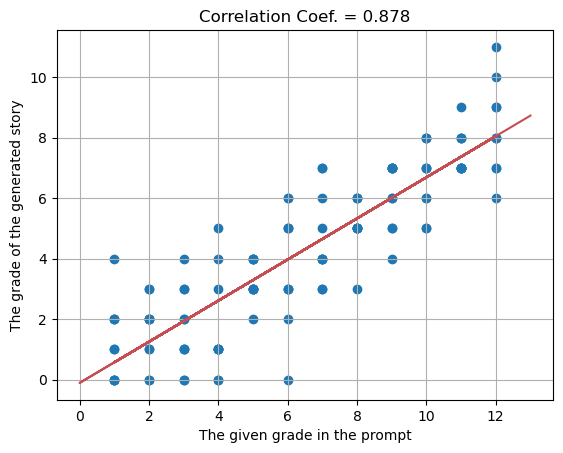

In [96]:
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rc_file_defaults()


plt.figure()
plt.scatter(real_grades, estimated_grades)
plt.ylabel("The grade of the generated story")
plt.xlabel("The given grade in the prompt")
corr = np.round(np.corrcoef(real_grades, estimated_grades)[1][0],3)
a, b = np.polyfit(real_grades, estimated_grades, 1)
x = np.array(real_grades + [min(real_grades)-1, max(real_grades)+1])
#add line of best fit to plot
plt.plot(x, a*x+b, 'r')
plt.title("Correlation Coef. = {}".format(corr))
plt.grid()
plt.show()


In [98]:
from numpy import random
import json

In [137]:
def load_vocab(filepath):
    fileObject = open(filepath, "r")
    jsonContent = fileObject.read()

    return json.loads(jsonContent)


def get_genre_vocab(genre):
    filepath = 'data/genre_words/processed/'
    if genre == 'science_fiction':
        filepath = filepath + 'sci-fi.json'
    elif genre == "horror":
        filepath = filepath + 'horror.json'
    elif genre == "fantasy":
        filepath = filepath + "fantasy.json"
    elif genre == "realistic_fiction":
        filepath = filepath + "realfic.json"

    return load_vocab(filepath)


def get_value_vocab(value):
    filepath = 'data/genre_words/processed/'
    if value == "love":
        filepath = filepath + 'love.json'
    elif value == "friendship":
        filepath = filepath + 'friendship.json'
    elif value == "determination":
        filepath = filepath + 'determination.json'
    elif value == "honesty":
        filepath = filepath + 'honesty.json'

    return load_vocab(filepath)


def rand_selection(vocab):
    newvocab = {}
    keys = list(vocab.keys())
    randlist = np.random.choice(len(keys), 300, replace=False)
    for index in randlist:
        newvocab[keys[index]] = vocab[keys[index]]
    return newvocab


def get_vocab(genre, value1, value2):
    vocab0, vocab1, vocab2 = {}, {}, {}
    genre = genre.lower()
    value1 = value1.lower()
    value2 = value2.lower()

    #get genre vocab
    vocab0 = get_genre_vocab(genre)
    #get value #1 vocab 
    if value1 != '':
        vocab1 = get_value_vocab(value1)
    #get value #2 vocab 
    if value2 != '':
        vocab2 = get_value_vocab(value2)
    vocab = {}
    for key in vocab0.keys():
        vocab[key] = vocab0[key]
    for key in vocab1.keys():
        vocab[key] = vocab1[key]
    for key in vocab2.keys():
        vocab[key] = vocab2[key]        
    # vocab = vocab0 | vocab1 | vocab2
    if len(vocab.keys()) > 300:
        vocab = rand_selection(vocab)
    return vocab


def get_starter(genre):
    if genre == 'science fiction':
        return scifi_starters
    elif genre == "horror":
        return horror_starters
    elif genre == "fantasy":
        return fantasy_starters
    elif genre == "realistic fiction":
        return realfic_starters


In [46]:
prompt = "<|startoftext|> <12> <action> determination friendship. One day, "
generated = torch.tensor(tokenizer.encode(prompt)).unsqueeze(0)
generated = generated.to(device)
generated_tokens = filtered_generate(model,tokenizer, generated, device, max_new_tokens=300, temperature=0.8, do_sample=False, top_k=5,\
                                     filter_words=[], bias_words=[], prevent_repition=True, prevent_repition_bias=1)
generated_story = tokenizer.decode(generated_tokens[0])#.split(">")[3]
print(generated_story)

<|startoftext|> <12> <action> determination friendship. One day,  Aravind (Vijaya Povirap), is a photographer who got himself transferred, in the middle of nowhere with an assignment. While he is being sent a guide there to cover a political news championship in a rural area of Kerala - He meets a group led behind a circle ostensibly involved in the publication, called The photographski and some more; A strange and menacing incidents take place, further complicating Aravand's life further, as he finds himself drawn into an alluring local environment that has been piqued of both admiration and hate for politicians and self-st creeped snobs. He soon realizes the power and the slush he finds amongst a group, is very real, there's power and has a edge in it and also, one with a powerful and tainted Minister, thus moves into the picture and his identity as the subject of The Pluncher Party's Kerala Cabinet. This new Aravind, in spite of all attempts, to charm the people behind The Plen's de

In [100]:
# def get_words_not_for_kids(levels_address = 'english_level/processed_words_level/'):
#     # returns 1 for kids, 0 for adults
#     A = []
#     B = []
#     C = []
#     with open(levels_address + "level_0.txt",'r') as f:
#         A.extend(f.readlines())
#         A = [w.strip() for w in A]
#     with open(levels_address + "level_1.txt",'r') as f:
#         B.extend(f.readlines())
#         B = [w.strip() for w in B]
#     with open(levels_address + "level_2.txt",'r') as f:
#         B.extend(f.readlines())
#         B = [w.strip() for w in B]
#     with open(levels_address + "level_3.txt",'r') as f:
#         C.extend(f.readlines())
#         C = [w.strip() for w in C]    
#     with open(levels_address + "level_4.txt",'r') as f:
#         C.extend(f.readlines())
#         C = [w.strip() for w in C]    
#     return list(set(C) - set(B) - set(A))

# difficult_words = get_words_not_for_kids(levels_address = 'data/english_level/processed_words_level/')

In [104]:
# difficult_words.sort(key=len)
# difficult_words = difficult_words[::-1]
# difficult_words = [d for d in difficult_words if "/" not in d]
# difficult_words_selected = difficult_words[:50]

## Model Fine-tuning (Second step)

In [106]:
import pandas as pd
import numpy as np

df = pd.read_excel("./data/raw_data/childrenstories.xlsx")
values = list(df.value.dropna())
values = [[q.strip() for q in v.split(",")] for v in values]
all_values_set = []
for v in values:
    all_values_set = all_values_set + v
all_values_set = list(set(all_values_set))

texts = list(df.text.dropna())

In [108]:
def add_labels_values(story,values=[]):
    story = story.replace('"',"").replace("\'","").replace('\n',"")
    genre = get_genre(story)
    grade = str(int(calculate_grade(story)))
    sample_processed_story = "<{}> <{}>".format(grade, 'fantasy')
    for v in values:
        sample_processed_story += " <{}>".format(v)
    sample_processed_story += " {}".format(story)
    return sample_processed_story

In [109]:
print(len(texts))
processed_stories = []
for i in tqdm(range(len(texts))):
    try:
        processed_stories.append(add_labels_values(texts[i], values[i]))
    except:
        pass

72


100%|██████████████████████████████████████████████████████████████████████████████████| 72/72 [01:27<00:00,  1.22s/it]


In [111]:
print(processed_stories[0])

<6> <fantasy> <appearance> <beauty> An Ant nimbly running about in the sunshine in search of food came across a Chrysalis that was very near its time of change. The Chrysalis moved its tail, and thus attracted the attention of the Ant, who then saw for the first time that it was alive. Poor, pitiable animal! cried the Ant disdainfully. What a sad fate is yours!While I can run hither and thither, at my pleasure, and, if I wish, ascend the tallest tree, you lie imprisoned here in your shell, with power only to move a joint or two of your scaly tail. The Chrysalis heard all this, but did not try to make any reply. A few days after, when the Ant passed that way again, nothing but the shell remained. Wondering what had become of its contents, he felt himself suddenlyshaded and fanned by the gorgeous wings of a beautiful Butterfly. Behold in me, said the Butterfly, your much-pitied friend! Boast now of your powers to run and climb as long as you can get me to listen. So saying, the Butterfly

In [113]:
df = pd.DataFrame(processed_stories,columns =['story'])

In [121]:
df.dropna(inplace=True) #remove NA values
df_stories_2 = df.story.copy() #just use the main bio text in this example
df_stories_2

0     <6> <fantasy> <appearance> <beauty> An Ant nim...
1     <6> <fantasy> <cooperation> <friendship> <team...
2     <6> <fantasy> <mindfulness> <foresight> In a f...
3     <5> <fantasy> <perserverance> <confidence> <hu...
4     <9> <fantasy> <appearance> <deception> A Wolf ...
                            ...                        
67    <5> <fantasy> <perserverance> <determination> ...
68    <5> <fantasy> <appearance> <beauty> <happiness...
69    <5> <fantasy> <happiness> <love> Once upon a t...
70    <4> <fantasy> <greed> <cleverness perserveranc...
71    <5> <fantasy> <greed> <atonement> <cooperation...
Name: story, Length: 72, dtype: object

In [116]:
all_values_set

['appearance',
 'perserverance',
 'cleverness',
 'naivety',
 'hubris',
 'cooperation',
 'beauty',
 'determination',
 'kindness',
 'foresight',
 'greed',
 'love',
 'friendship',
 'sharing',
 'confidence',
 'teamwork',
 'atonement',
 'patience',
 'mindfulness',
 'cleverness perserverance',
 'honesty',
 'happiness',
 'strength',
 'deception',
 'quality']

In [117]:
new_tokens = ["<{}>".format(v) for v in all_values_set]
print(new_tokens)

['<appearance>', '<perserverance>', '<cleverness>', '<naivety>', '<hubris>', '<cooperation>', '<beauty>', '<determination>', '<kindness>', '<foresight>', '<greed>', '<love>', '<friendship>', '<sharing>', '<confidence>', '<teamwork>', '<atonement>', '<patience>', '<mindfulness>', '<cleverness perserverance>', '<honesty>', '<happiness>', '<strength>', '<deception>', '<quality>']


In [118]:
for t in new_tokens:
    tokenizer.add_tokens(t)

In [119]:
len(tokenizer)

50302

In [122]:
dataset = GPT2Dataset(df_stories_2, tokenizer, max_length=512)

# Split into training and validation sets
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

   64 training samples
    8 validation samples


In [123]:
configuration = GPT2Config.from_pretrained('./gpt2_all_story_model_save_huggingface/', output_hidden_states=False)

model = GPT2LMHeadModel.from_pretrained('./gpt2_all_story_model_save_huggingface/', config=configuration)

model.resize_token_embeddings(len(tokenizer))

# cpu is enough :)
device = torch.device("cpu")
model.to(device)

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50302, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0): GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
      (1): GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dro

In [124]:
batch_size = 4
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )
		
device = torch.device("cpu")
model.to(device)


epochs = 10
learning_rate = 5e-5
warmup_steps = 1e2
epsilon = 1e-8

# sample_every = 20

optimizer = AdamW(model.parameters(), lr = learning_rate, eps = epsilon)

total_steps = len(train_dataloader) * epochs

scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = warmup_steps, 
                                            num_training_steps = total_steps)




In [125]:
def format_time(elapsed):
    return str(datetime.timedelta(seconds=int(round((elapsed)))))

In [126]:
total_t0 = time.time()

training_stats = []
val_losses = []
device = torch.device("cpu")
model = model.to(device)

output_dir = './gpt2_all_story_model_save_huggingface_step2/'

if not os.path.exists(output_dir):
    os.makedirs(output_dir)

for epoch_i in range(0, epochs):

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    t0 = time.time()

    total_train_loss = 0

    model.train()

    for step, batch in enumerate(train_dataloader):

        b_input_ids = batch[0].to(device)
        b_labels = batch[0].to(device)
        b_masks = batch[1].to(device)

        model.zero_grad()        

        outputs = model(  b_input_ids,
                          labels=b_labels, 
                          attention_mask = b_masks,
                          token_type_ids=None
                        )

        loss = outputs[0]  

        batch_loss = loss.item()
        total_train_loss += batch_loss
        loss.backward()
        optimizer.step()
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)       
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================

    print("")
    print("Running Validation...")

    t0 = time.time()

    model.eval()

    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        b_input_ids = batch[0].to(device)
        b_labels = batch[0].to(device)
        b_masks = batch[1].to(device)
        
        with torch.no_grad():        

            outputs  = model(b_input_ids, 
#                            token_type_ids=None, 
                             attention_mask = b_masks,
                            labels=b_labels)
          
            loss = outputs[0]  
            
        batch_loss = loss.item()
        total_eval_loss += batch_loss        

    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    validation_time = format_time(time.time() - t0)    
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))
    
    val_losses.append(avg_val_loss)
    # Save the model with best accuracy on the validation set
    if (len(val_losses)>1 and avg_val_loss < np.min(val_losses[:-1])) or len(val_losses)==1:
        model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
        model_to_save.save_pretrained(output_dir)
        tokenizer.save_pretrained(output_dir)

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")
print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 10 ========
Training...

  Average training loss: 2.73
  Training epoch took: 0:04:21

Running Validation...
  Validation Loss: 2.59
  Validation took: 0:00:11

======== Epoch 2 / 10 ========
Training...

  Average training loss: 2.60
  Training epoch took: 0:04:18

Running Validation...
  Validation Loss: 2.56
  Validation took: 0:00:12

======== Epoch 3 / 10 ========
Training...

  Average training loss: 2.55
  Training epoch took: 0:04:16

Running Validation...
  Validation Loss: 2.53
  Validation took: 0:00:11

======== Epoch 4 / 10 ========
Training...

  Average training loss: 2.49
  Training epoch took: 0:04:14

Running Validation...
  Validation Loss: 2.50
  Validation took: 0:00:11

======== Epoch 5 / 10 ========
Training...

  Average training loss: 2.41
  Training epoch took: 0:04:16

Running Validation...
  Validation Loss: 2.47
  Validation took: 0:00:11

======== Epoch 6 / 10 ========
Training...

  Average training loss: 2.33
  Training epoch took: 0:

In [134]:
model.eval()

prompt = "<|startoftext|> <6> <fantasy> <love>"

generated = torch.tensor(tokenizer.encode(prompt)).unsqueeze(0)
generated = generated.to(device)

print(generated)

sample_outputs = model.generate(
                                generated, 
                                #bos_token_id=random.randint(1,30000),
                                do_sample=True,   
                                top_k=20, 
                                max_length = 200,
                                top_p=0.95, 
                                num_return_sequences=3
                                )

for i, sample_output in enumerate(sample_outputs):
  print("{}: {}\n\n".format(i, tokenizer.decode(sample_output, skip_special_tokens=True)))

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


tensor([[50257, 50264,    27, 50276,    29, 50288]])
0: <6> < fantasy > <love> <perserverance> <strength> A young boy, who lived in Africa, fell in love with a man named Nani. He saw her and his mother together. They lived happily ever after.He loved Nani. He loved her deeply, but he was too afraid of what he would do to him. His mother was very happy to see him and married Nani.He was too afraid of what he would do to Nani, but her mother had not. He loved her deeply and very much. He loved her deeply. He loved Nani very much. He loved her so much. He loved her very much. But she could not bear to live away any longer. It was too late.A day while she was sleeping in a small room. She had heard her mother crying for help. She was asleep in bed. She was very happy.She could not sleep, because she was very close to dying from a fever.She could not sleep.She could not sleep


1: <6> < fantasy > <love> <perserverance> A man is about to be sacrificed in order to save a princess who had fall

In [133]:
# Display floats with two decimal places.
# pd.set_option('precision', 2)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# A hack to force the column headers to wrap.
#df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

# Display the table.
df_stats

,Training Loss,Valid. Loss,Training Time,Validation Time
epoch,,,,
1,2.729474,2.589924,0:04:21,0:00:11
2,2.600548,2.562839,0:04:18,0:00:12
3,2.548863,2.529752,0:04:16,0:00:11
4,2.485149,2.498734,0:04:14,0:00:11
5,2.414100,2.472119,0:04:16,0:00:11
6,2.331565,2.450665,0:04:19,0:00:11
7,2.254478,2.435557,0:04:18,0:00:12
8,2.182169,2.427783,0:04:20,0:00:11
9,2.128861,2.424704,0:04:17,0:00:12


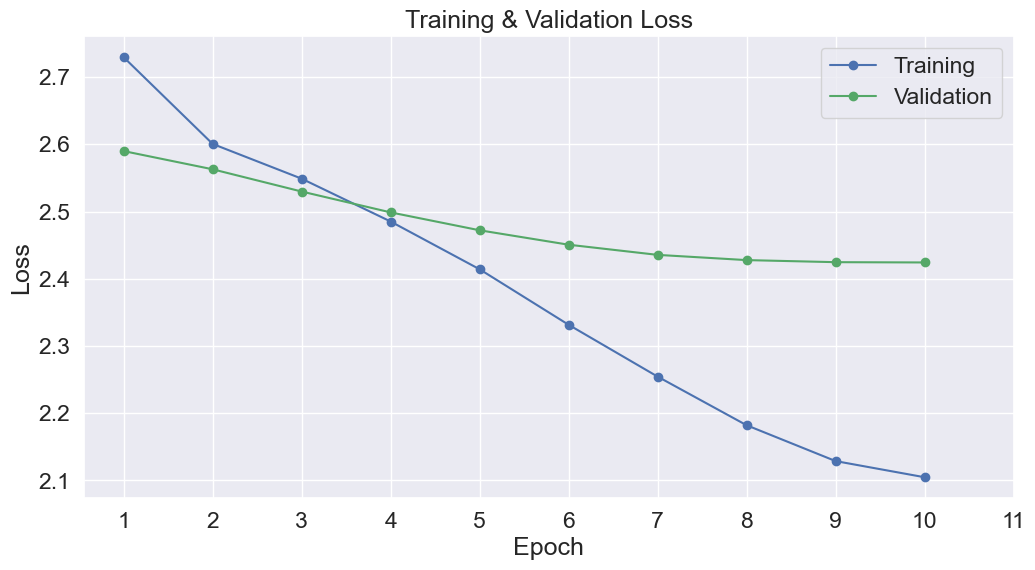

In [131]:
# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([i+1 for i in range(1+len(df_stats['Training Loss']))])

plt.show()

In [141]:
genre = "horror"
value_1 = "friendship"
value_2 = "love"
grade = 6
vocab_bias = get_vocab(genre, value_1, value_2)

In [142]:
prompt = "<|startoftext|> <{}> <{}> <{}> <{}>. One day, ".format(grade, genre, value_1, value_2)
generated = torch.tensor(tokenizer.encode(prompt)).unsqueeze(0)
generated = generated.to(device)
generated_tokens = filtered_generate(model,tokenizer, generated, device, max_new_tokens=300, temperature=0.8, do_sample=False, top_k=5,\
                                     filter_words=[], bias_words=vocab_bias, prevent_repition=True, prevent_repition_bias=1)
generated_story = tokenizer.decode(generated_tokens[0])#.split(">")[3]
print(generated_story)

<|startoftext|> <6> < horror > <friendship> <love>. One day,  The king was in a terrible mood of mourning; he was so afraid of anyone that even he would leave the kingdom, and he decided to take a vow to bring all of this into a secret passage.  There is a great ocean and there is an enormous gold mine. There is an enormous gold mine, but there has been a long gap.  It is a great gold-mine and there is plenty that could be hidden somewhere, said an employee who gave his name as  The King’ and gave him the nickname ”King,“ The golden mine!  There is no gold. No, no gold coins, not no jewels.  The goldmine, of the King, was very precious. He gave the royal guard to all the royal servants.  The king sent his servants to take over the reins to that very place.  But, the servants did not know who they were, nor who their master really is, but what the king is really up to is the gold mine that the King has been working at and will do.  It will have to be done by morning. The next time the g

In [143]:
print(generated_story.split("<|endoftext|>")[0])

<|startoftext|> <6> < horror > <friendship> <love>. One day,  The king was in a terrible mood of mourning; he was so afraid of anyone that even he would leave the kingdom, and he decided to take a vow to bring all of this into a secret passage.  There is a great ocean and there is an enormous gold mine. There is an enormous gold mine, but there has been a long gap.  It is a great gold-mine and there is plenty that could be hidden somewhere, said an employee who gave his name as  The King’ and gave him the nickname ”King,“ The golden mine!  There is no gold. No, no gold coins, not no jewels.  The goldmine, of the King, was very precious. He gave the royal guard to all the royal servants.  The king sent his servants to take over the reins to that very place.  But, the servants did not know who they were, nor who their master really is, but what the king is really up to is the gold mine that the King has been working at and will do.  It will have to be done by morning. The next time the g